In [ ]:
import torch
from torch import nn
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from einops import rearrange
import numpy as np
from sklearn.metrics import accuracy_score
import random

# Часть 1 (Автоэнкодер)

In [ ]:
def get_data(data_dir="./data"):
    transform = transforms.Compose(
        [
            transforms.ToTensor(),
        ]
    )

    trainset = datasets.MNIST(
        root=data_dir, train=True, download=True, transform=transform
    )

    testset = datasets.MNIST(
        root=data_dir, train=False, download=True, transform=transform
    )
    return trainset, testset

In [ ]:
class Net1(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 36),
            nn.ReLU(),
            nn.Linear(36, 18),
            nn.ReLU(),
            nn.Linear(18, 9),
        )
        self.decoder = nn.Sequential(
            nn.Linear(9, 18),
            nn.ReLU(),
            nn.Linear(18, 36),
            nn.ReLU(),
            nn.Linear(36, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid(),
        )

    def forward(self, x: torch.Tensor):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
class Net2(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 36),
        )
        self.decoder = nn.Sequential(
            nn.Linear(36, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid(),
        )

    def forward(self, x: torch.Tensor):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
# import wandb


def train_loop(dataloader, model, loss_fn, optimizer, device: str):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    train_loss = 0
    for batch, (X, _) in enumerate(dataloader):
        X = X.to(device)
        X = rearrange(X, "b c h w -> b c (h w)")

        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, X)
        train_loss += loss

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 10 == 0:
            loss, current = loss.item(), batch * dataloader.batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    # wandb.log({"train_loss": train_loss / num_batches})


def test_loop(dataloader, model, loss_fn, device):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    num_batches = len(dataloader)
    test_loss = 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, _ in dataloader:
            X = X.to(device)
            X = rearrange(X, "b c h w -> b c (h w)")
            pred = model(X)
            test_loss += loss_fn(pred, X).item()

    test_loss /= num_batches

    # wandb.log({"test_loss": test_loss, "test_accuracy": accuracy})

    print(f" vg loss: {test_loss:>8f} \n")

In [ ]:
device = "cuda"

trainset, testset = get_data()

batch_size = 32
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True, num_workers=2
)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size, shuffle=False, num_workers=2
)
net = Net2()
net.to(device)

loss_fn = nn.MSELoss()
params = dict(lr=1e-3, weight_decay=1e-8)
optimizer = torch.optim.Adam(net.parameters(), **params)

"""wandb.init(
      # Set the project where this run will be logged
      project="ML2_4_1",
      # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
      name=f"experiment_2"
      )"""

epochs = 10
for t in range(epochs):
    print(f"Epoch {t + 1}\n-------------------------------")
    train_loop(trainloader, net, loss_fn, optimizer, device)
    test_loop(testloader, net, loss_fn, device)

torch.save(net.state_dict(), "model_weights.pth")
torch.save(optimizer.state_dict(), "optimizer_settings.pth")

# wandb.finish()

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 480kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.41MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.42MB/s]


Epoch 1
-------------------------------
loss: 0.233943  [   32/60000]
loss: 0.211092  [  352/60000]
loss: 0.094410  [  672/60000]
loss: 0.078229  [  992/60000]
loss: 0.074338  [ 1312/60000]
loss: 0.078403  [ 1632/60000]
loss: 0.076581  [ 1952/60000]
loss: 0.078829  [ 2272/60000]
loss: 0.071034  [ 2592/60000]
loss: 0.064059  [ 2912/60000]
loss: 0.072043  [ 3232/60000]
loss: 0.066469  [ 3552/60000]
loss: 0.062763  [ 3872/60000]
loss: 0.065229  [ 4192/60000]
loss: 0.065719  [ 4512/60000]
loss: 0.069597  [ 4832/60000]
loss: 0.065289  [ 5152/60000]
loss: 0.059054  [ 5472/60000]
loss: 0.055431  [ 5792/60000]
loss: 0.065353  [ 6112/60000]
loss: 0.064692  [ 6432/60000]
loss: 0.064412  [ 6752/60000]
loss: 0.061240  [ 7072/60000]
loss: 0.056759  [ 7392/60000]
loss: 0.057653  [ 7712/60000]
loss: 0.058451  [ 8032/60000]
loss: 0.059152  [ 8352/60000]
loss: 0.054283  [ 8672/60000]
loss: 0.057546  [ 8992/60000]
loss: 0.054210  [ 9312/60000]
loss: 0.059199  [ 9632/60000]
loss: 0.055456  [ 9952/60000]


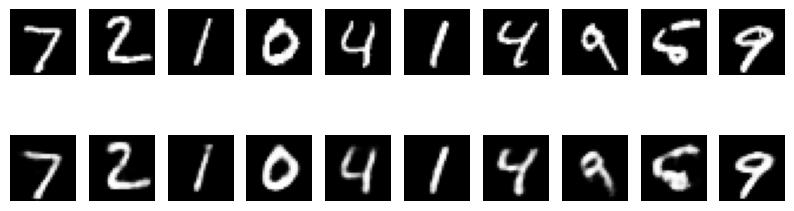

In [ ]:
net.eval()
dataiter = iter(testloader)
images, _ = next(dataiter)

images = images.to(device)
images = rearrange(images, "b c h w -> b c (h w)")
reconstructed = net(images)

fig, axes = plt.subplots(nrows=2, ncols=10, figsize=(10, 3))
for i in range(10):
    axes[0, i].imshow(images[i].cpu().detach().numpy().reshape(28, 28), cmap="gray")
    axes[0, i].axis("off")
    axes[1, i].imshow(
        reconstructed[i].cpu().detach().numpy().reshape(28, 28), cmap="gray"
    )
    axes[1, i].axis("off")
plt.show()

In [ ]:
net.encoder[::2] + net.decoder[::2]

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): Linear(in_features=128, out_features=64, bias=True)
  (2): Linear(in_features=64, out_features=36, bias=True)
  (3): Linear(in_features=36, out_features=18, bias=True)
  (4): Linear(in_features=18, out_features=9, bias=True)
  (5): Linear(in_features=9, out_features=18, bias=True)
  (6): Linear(in_features=18, out_features=36, bias=True)
  (7): Linear(in_features=36, out_features=64, bias=True)
  (8): Linear(in_features=64, out_features=128, bias=True)
  (9): Linear(in_features=128, out_features=784, bias=True)
)

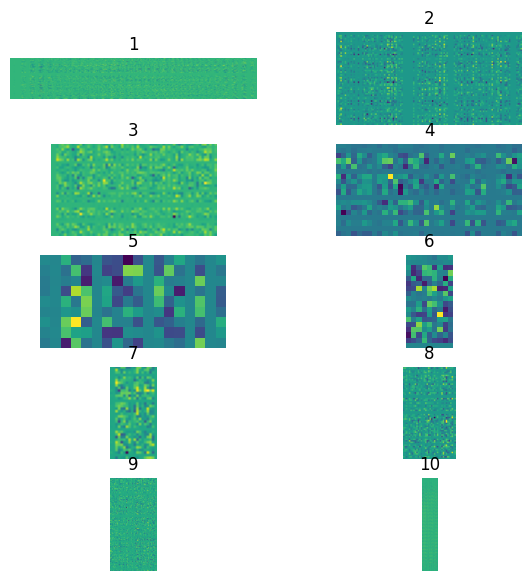

In [ ]:
from matplotlib import pyplot as plt

weights = net.encoder[::2] + net.decoder[::2]
figure = plt.figure(figsize=(7, 7))
cols, rows = 2, 5
for i in range(0, rows * cols):
    img = weights[i].weight.data.cpu()
    figure.add_subplot(rows, cols, i + 1)
    plt.title(i + 1)
    plt.axis("off")
    plt.imshow(img)
plt.show()

# Часть 2 (NLP)

In [ ]:
import string
import unicodedata

# We can use "_" to represent an out-of-vocabulary character, that is, any character we are not handling in our model
allowed_characters = string.ascii_letters + " .,;'" + "_"
n_letters = len(allowed_characters)


# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return "".join(
        c
        for c in unicodedata.normalize("NFD", s)
        if unicodedata.category(c) != "Mn" and c in allowed_characters
    )


# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    # return our out-of-vocabulary character if we encounter a letter unknown to our model
    if letter not in allowed_characters:
        return allowed_characters.find("_")
    else:
        return allowed_characters.find(letter)


# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor


def label_from_output(output, output_labels):
    top_n, top_i = output.topk(1)
    label_i = top_i[0].item()
    return output_labels[label_i], label_i

In [ ]:
from io import open
import glob
import os
import time

from torch.utils.data import Dataset


class NamesDataset(Dataset):
    def __init__(self, data_dir):
        self.data_dir = data_dir  # for provenance of the dataset
        self.load_time = time.localtime  # for provenance of the dataset
        labels_set = set()  # set of all classes

        self.data = []
        self.data_tensors = []
        self.labels = []
        self.labels_tensors = []

        # read all the ``.txt`` files in the specified directory
        text_files = glob.glob(os.path.join(data_dir, "*.txt"))
        for filename in text_files:
            label = os.path.splitext(os.path.basename(filename))[0]
            labels_set.add(label)
            lines = open(filename, encoding="utf-8").read().strip().split("\n")
            for name in lines:
                self.data.append(name)
                self.data_tensors.append(lineToTensor(name))
                self.labels.append(label)

        # Cache the tensor representation of the labels
        self.labels_uniq = list(labels_set)
        for idx in range(len(self.labels)):
            temp_tensor = torch.tensor(
                [self.labels_uniq.index(self.labels[idx])], dtype=torch.long
            )
            self.labels_tensors.append(temp_tensor)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data_item = self.data[idx]
        data_label = self.labels[idx]
        data_tensor = self.data_tensors[idx]
        label_tensor = self.labels_tensors[idx]

        return label_tensor, data_tensor, data_label, data_item

In [ ]:
def get_data(data_dir: str):
    alldata = NamesDataset(data_dir)
    train_set, test_set = torch.utils.data.random_split(alldata, [0.85, 0.15])
    return alldata, train_set, test_set


In [ ]:
import torch.nn as nn


class CharRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CharRNN, self).__init__()

        self.rnn = nn.RNN(input_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, line_tensor):
        rnn_out, hidden = self.rnn(line_tensor)
        output = self.h2o(hidden[0])
        output = self.softmax(output)

        return output

In [17]:
class CharLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CharLSTM, self).__init__()

        self.rnn = nn.LSTM(input_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, line_tensor):
        rnn_out, (hidden, cell) = self.rnn(line_tensor)
        output = self.h2o(hidden[0])
        output = self.softmax(output)

        return output

In [18]:
class CharGRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CharGRU, self).__init__()

        self.rnn = nn.GRU(input_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, line_tensor):
        rnn_out, hidden = self.rnn(line_tensor)
        output = self.h2o(hidden[0])
        output = self.softmax(output)

        return output

In [19]:
def evaluate(rnn, test_data, criterion=nn.NLLLoss()):
    """Evaluate the model on test data and return loss and accuracy"""
    rnn.eval()
    total_loss = 0
    total_accuracy = 0

    with torch.no_grad():
        for i in range(len(test_data)):
            (label_tensor, text_tensor, label, text) = test_data[i]
            output = rnn(text_tensor)
            loss = criterion(output, label_tensor)
            total_loss += loss.item()

            # Calculate accuracy - note: need to convert tensors to numpy arrays first
            pred = torch.argmax(output, dim=1).numpy()
            true = label_tensor.numpy()
            total_accuracy += accuracy_score(true, pred)

    avg_loss = total_loss / len(test_data)
    avg_accuracy = total_accuracy / len(test_data)
    return avg_loss, avg_accuracy

In [ ]:
def train(
    rnn,
    training_data,
    test_data=None,
    n_epoch=10,
    n_batch_size=64,
    report_every=1,
    learning_rate=0.2,
    criterion=nn.NLLLoss(),
):
    """
    Learn on a batch of training_data for a specified number of iterations and reporting thresholds
    Returns: (train_losses, train_accuracies, test_losses, test_accuracies)
    """
    # Initialize tracking variables
    current_loss = current_accuracy = 0
    all_losses = []
    all_accuracies = []
    test_losses = []
    test_accuracies = []

    rnn.train()
    optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)

    print(f"training on data set with n = {len(training_data)}")

    for epoch in range(1, n_epoch + 1):
        rnn.zero_grad()  # clear the gradients

        # Create minibatches
        batches = list(range(len(training_data)))
        random.shuffle(batches)
        batches = np.array_split(batches, len(batches) // n_batch_size)

        batch_loss = batch_accuracy = 0

        for idx, batch in enumerate(batches):
            batch_loss = 0
            batch_accuracy = 0

            for i in batch:  # for each example in this batch
                (label_tensor, text_tensor, label, text) = training_data[i]
                output = rnn(text_tensor)
                loss = criterion(output, label_tensor)

                # Calculate accuracy
                pred = torch.argmax(output, dim=1).numpy()
                true = label_tensor.numpy()
                accuracy = accuracy_score(true, pred)

                batch_accuracy += accuracy
                batch_loss += loss

            # Optimize parameters
            batch_loss.backward()
            nn.utils.clip_grad_norm_(rnn.parameters(), 3)
            optimizer.step()
            optimizer.zero_grad()

            current_loss += batch_loss.item() / len(batch)
            current_accuracy += batch_accuracy / len(batch)

        # Store training metrics
        epoch_loss = current_loss / len(batches)
        epoch_accuracy = current_accuracy / len(batches)
        all_losses.append(epoch_loss)
        all_accuracies.append(epoch_accuracy)

        # Evaluate on test data if provided
        if test_data is not None:
            test_loss, test_acc = evaluate(rnn, test_data, criterion)
            test_losses.append(test_loss)
            test_accuracies.append(test_acc)

        if epoch % report_every == 0:
            log_msg = (
                f"{epoch} ({epoch / n_epoch:.0%}): \t train loss = {epoch_loss:.4f}"
            )
            if test_data is not None:
                log_msg += f", test loss = {test_loss:.4f}"
            print(log_msg)

        current_loss = current_accuracy = 0

    return all_losses, all_accuracies, test_losses, test_accuracies

In [ ]:
device = "cuda"

alldata, train_set, test_set = get_data("/content/drive/MyDrive/Data/nlp_data/names")

n_hidden = 128
rnn = CharGRU(n_letters, n_hidden, len(alldata.labels_uniq))

start = time.time()
train_losses, train_accuracies, test_losses, test_accuracies = train(
    rnn, train_set, test_data=test_set, n_epoch=10
)
end = time.time()
print(f"training took {end - start}s")

training on data set with n = 17063
1 (10%): 	 train loss = 1.4227, test loss = 1.1177
2 (20%): 	 train loss = 1.0723, test loss = 0.9561
3 (30%): 	 train loss = 0.9551, test loss = 0.8559
4 (40%): 	 train loss = 0.8600, test loss = 0.7728
5 (50%): 	 train loss = 0.7846, test loss = 0.7191
6 (60%): 	 train loss = 0.7143, test loss = 0.6772
7 (70%): 	 train loss = 0.6657, test loss = 0.6575
8 (80%): 	 train loss = 0.6152, test loss = 0.6364
9 (90%): 	 train loss = 0.5737, test loss = 0.5649
10 (100%): 	 train loss = 0.5364, test loss = 0.5749
training took 554.8639256954193s


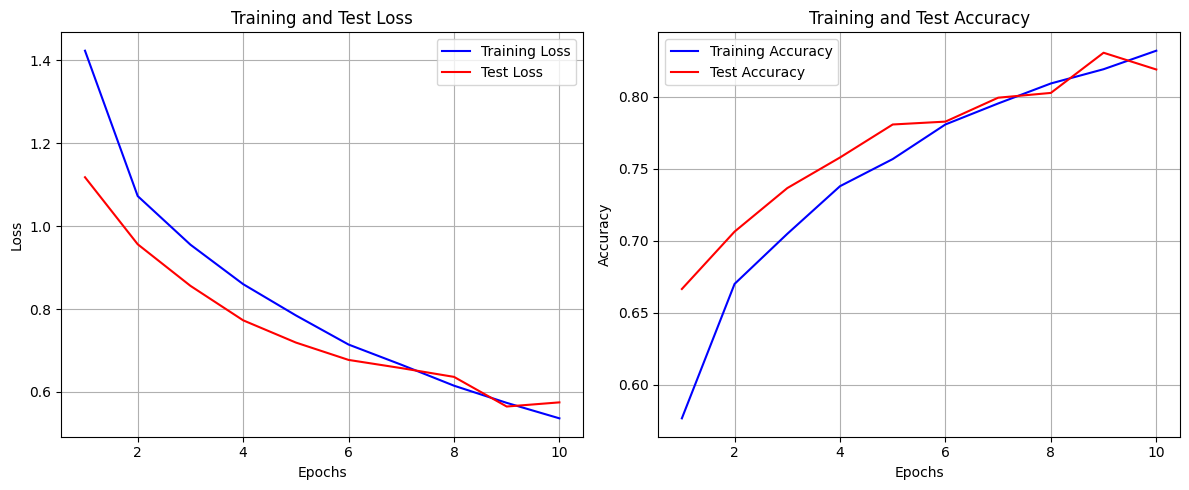

In [ ]:
import matplotlib.pyplot as plt


def plot_training_metrics(train_losses, train_accuracies, test_losses, test_accuracies):
    """
    Plot training and test metrics (loss and accuracy) across epochs

    Args:
        train_losses: list of training losses per epoch
        train_accuracies: list of training accuracies per epoch
        test_losses: list of test losses per epoch
        test_accuracies: list of test accuracies per epoch
    """
    epochs = range(1, len(train_losses) + 1)

    # Create figure with two subplots
    plt.figure(figsize=(12, 5))

    # Plot Losses
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, "b-", label="Training Loss")
    if test_losses:  # Only plot if test losses were computed
        plt.plot(epochs, test_losses, "r-", label="Test Loss")
    plt.title("Training and Test Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)

    # Plot Accuracies
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, "b-", label="Training Accuracy")
    if test_accuracies:  # Only plot if test accuracies were computed
        plt.plot(epochs, test_accuracies, "r-", label="Test Accuracy")
    plt.title("Training and Test Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


plot_training_metrics(train_losses, train_accuracies, test_losses, test_accuracies)